# Building MAML From Scratch
MAML 是最為廣泛使用的Meta laerning方法，核心為learn to initialize。

可以在不改變model結構之下，使model有更好的initialzation。
1. 假設一組model的參數$\phi$初始值為$\phi _0$
2. Adaptation: 經過一組source data訓練後經過gradient descent $g_1$應更新為$\phi_1$(圖中綠色)

(一般transfer learning就是重複上述步驟訓練好一個model，在新的task出來時直接使用該pre-trained model。)

3. Evaluation: 計算同一組source data再經過一組資料的訓練後應該要做gradient descent $g_2$。
4. Meta-update: 將${g_2}$乘以一個ratio成$\lambda g_2$作為update參數apply回$\phi _0$，則更新了pre-train model成$\phi_{M1}$，相較之下若是傳統Transfer learning 則是只知道更新到task optimal ($\phi_{T1}$)

不斷重複上述步驟於各組source data，可改善target training時model的初始參數，使得這個參數能很快gradient descent成各種target task所需的model

可以想像這個initial參數座標會在在各個task所需的參數座標的中心

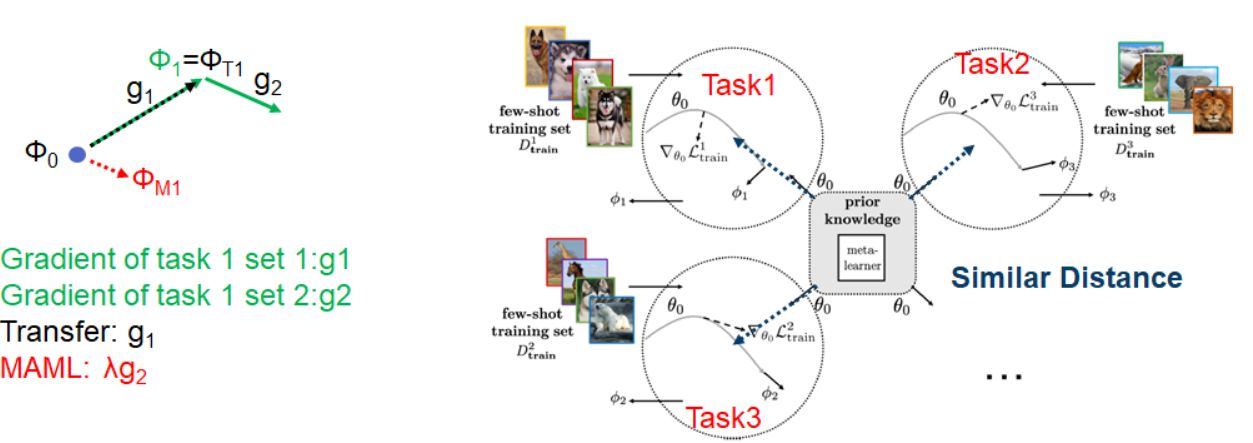

這次使用MAML實作在Omniglot資料集上：
* source有3856個來自不同語言的不同字符，target有659個不同字符
* 每個class有20張不同人手寫的同一個文字的圖片
* 每個task的source是隨機抽3個字符，每個字符5張照片做訓練
* query是同樣3個字符裡面另外1張照片，需推論這張照片屬於三個字符裡面哪一個

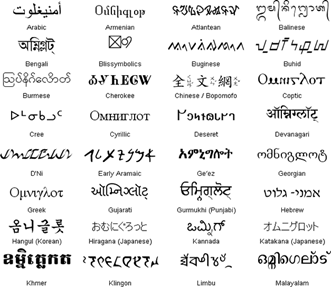

**程式碼部分會做以下部分：**
* Data Loader
* 建立模型
* 模型訓練
* 模型測試

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import os
import cv2
from tensorflow.keras import utils
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

import tensorflow as tf
from tensorflow import keras

gpus = tf.config.experimental.list_physical_devices(device_type="GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(device=gpu,enable=True)

In [2]:
# Config
WAYS=3
SHOTS=5
QUERIES=1

# Data Loader
首先讀取資料夾名稱

In [3]:
# download from GoogleDrive
# https://drive.google.com/file/d/1FLDrQ0k-iJ-mk8ors0WItqvwgu0w9J0U/view

In [4]:
DATA_DIR='../datasets/Omniglot_splited'
# training v.s test Omniglot classes
source_classes = glob(DATA_DIR+'/images_background/*/*')
target_classes = glob(DATA_DIR+'/images_evaluation/*/*')
print(f'字符種類 train: test = {len(source_classes)} : {len(target_classes)}')

字符種類 train: test = 3856 : 659


In [5]:
# dataset 結構: images_background/語言/字符id
source_classes[:5]

['../datasets/Omniglot_splited/images_background\\Alphabet_of_the_Magi.0\\character01',
 '../datasets/Omniglot_splited/images_background\\Alphabet_of_the_Magi.0\\character02',
 '../datasets/Omniglot_splited/images_background\\Alphabet_of_the_Magi.0\\character03',
 '../datasets/Omniglot_splited/images_background\\Alphabet_of_the_Magi.0\\character04',
 '../datasets/Omniglot_splited/images_background\\Alphabet_of_the_Magi.0\\character05']

../datasets/Omniglot_splited/images_background\Mkhedruli_(Georgian).270\character23\0751_02.png


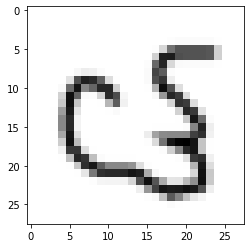

In [6]:
# 觀察圖片內容
path = np.random.choice(glob(DATA_DIR+'/images_background/*/*/*.png'), 1)[0]
img = cv2.imread(path)
img.shape
print(path)
plt.imshow(img)
plt.show()

#### Read Data

**1.製作讀取圖案並前處理的function**

使用cv2.imread讀檔案時，因為後續我們會使用tf.data.Dataset.list_files來列舉檔案名稱變成tf tensor，所以使用.numpy.decode()將其解碼為文字

前處理會將圖片從0-255拉到0-1之間，然後取圖片中間長寬為min_of_shape的區塊，這個大小是元圖長、寬中較小的那個值。

最後RESIZE到W,H大小

因為這組圖都是黑白的，所以原本的png檔讀出來後我只要RGB中任一channel就好了

In [7]:
W,H,CH = 64,64,1

def load_img(path, width = W, hight=H):
    img=cv2.imread(path.numpy().decode())[...,0].astype(np.float32)/255.
    min_of_shape = np.min(img.shape[:2])
    oh = (img.shape[0] - min_of_shape) // 2
    ow = (img.shape[1] - min_of_shape) // 2
    center_square = np.array([width,hight])// 2
    new_size=(width,hight)
    
    # cropping + resize
    img = img[oh:oh + min_of_shape, ow:ow + min_of_shape]
    img=np.expand_dims(cv2.resize(img, new_size),-1)
    return tf.constant(img-0.5)
SUFFIX='.png'

**2. 製作 Data Loader**
使用兩層tf.data.Dataset class來完成:
第一層random選取class，第二層random選取照片

實作上，第一層的loader會隨機去抽第二層的loader。

套用指定的way數、shot數、query數等等參數，製作data loader

In [8]:
map_fun=lambda string: tf.py_function(func=load_img,inp=[string], Tout=tf.float32)
# 指定抽照片的loader，每個class各有一個tf.data.Dataset.list_files的loader
# 這邊要指定格式化不然會有bug, 會搜到多餘的暫存檔案
source_sub = [
  tf.data.Dataset.list_files(os.path.join(sc,'????_??.png'), shuffle=True)
  .map(map_fun)
  for sc in source_classes
]
target_sub = [
  tf.data.Dataset.list_files(os.path.join(sc,'????_??.png'), shuffle=True)
  .map(map_fun)
  for sc in target_classes
]

# 使用tf.data.Dataset.from_generator作class loader 的loader時需要呼叫一個函數
# 因此這邊組一個函數丟給它
def gen(all_sub):
    # 這個函數會丟進一個list的file loader，首先先permute一下順序，目的是希望打亂task進到model的順序
    order=np.random.permutation(len(all_sub))
    for tasks in range(len(all_sub)//WAYS):
        # 每次抽取WAYS個file loader，後面使用batch來抽數張照片
        # prefetch可以將資料先放進memory中WAYS個batch，下個batch要用就會比較快
        picked=[all_sub[tt] for tt in order[WAYS*tasks:WAYS*(tasks+1)]]
        # Support
        support = tf.concat(
          [
            next(
              iter(
                  sub.batch(SHOTS).prefetch(WAYS)
              )
              ) for sub in picked
          ]
          , axis=0)
        # 這邊每個task的label都是自己取的，編號從0開始加到WAYS-1
        support_label=tf.repeat(tf.range(WAYS,dtype=tf.float32),SHOTS)
        # Shuffle support
        order2=np.random.permutation(WAYS*SHOTS)
        support=tf.stack([support[ii] for ii in order2])
        support_label=tf.stack([support_label[ii] for ii in order2])

        # Query
        query_label=np.random.choice(range(WAYS), size=QUERIES, replace=False)
        query = tf.concat(
          [
            next(
              iter(
                  picked[idx].batch(1).prefetch(1)
              )
              ) for idx in query_label
          ]
          , axis=0)
        yield (support,query),(support_label,query_label)

def gen_source():
    return gen(source_sub)
def gen_target():
    return gen(target_sub)

data_source = tf.data.Dataset.from_generator(gen_source,
                        output_types=((tf.float32,tf.float32),(tf.float32,tf.float32)),
                        output_shapes=(((WAYS*SHOTS,W,H,CH),(QUERIES,W,H,CH)),((WAYS*SHOTS,),(QUERIES,)))
                        )
data_target = tf.data.Dataset.from_generator(gen_target,
                        output_types=((tf.float32,tf.float32),(tf.float32,tf.float32)),
                        output_shapes=(((WAYS*SHOTS,W,H,CH),(QUERIES,W,H,CH)),((WAYS*SHOTS,),(QUERIES,)))
                        )

In [9]:
# Hyperparameters
BATCH_SIZE = 32
max_epoch = 40
inner_train_step = 1
inner_lr = 0.4
meta_lr = 0.001
meta_batch_size = 32
eval_batches = test_batches = 20


# 建立模型
使用簡單的3層CNN模型來做backbone

In [10]:
class MAML(keras.Model):
    def __init__(self, num_cls):
        super().__init__()
        self.block1 = self.build_block(16)
        self.block2 = self.build_block(32)
        self.block3 = self.build_block(64)
        self.flat = keras.layers.Flatten()
        self.out = keras.layers.Dense(num_cls, activation='softmax')
    def build_block(self, filters):
        return [
            keras.layers.Conv2D(filters, 3, padding='same'),
            keras.layers.BatchNormalization(),
            keras.layers.Activation(keras.activations.relu),
            keras.layers.MaxPooling2D()]
    def forward_block(self, x, block):
        for l in block: x = l(x)
        return x
    def forward(self, x):
        x = self.forward_block(x, self.block1)
        x = self.forward_block(x, self.block2)
        x = self.forward_block(x, self.block3)
        x = self.flat(x)
        x = self.out(x)
        return x
    def build_graph(self):
        x = keras.layers.Input(shape=(W, H, CH))
        return keras.models.Model(inputs=[x], outputs=self.forward(x))

MAML需要在每次進行task training前將model weight儲存，因此先設好function

In [11]:
def copy_model(model, x):
    copied_model = MAML(num_cls=WAYS)
    # If we don't run this step the weights are not "initialized"
    # and the gradients will not be computed.
    copied_model.forward(tf.convert_to_tensor(x))
    copied_model.set_weights(model.get_weights().copy())
    return copied_model

def compute_loss(model, x, y):
    logits = model.forward(x)
    loss = keras.losses.sparse_categorical_crossentropy(y, logits)
    return loss, logits

In [12]:
model = MAML(num_cls=WAYS)
optimizer = keras.optimizers.Adam(learning_rate=meta_lr)
loss_fn = keras.losses.sparse_categorical_crossentropy
acc_fn = keras.metrics.categorical_accuracy

這邊是meta training的function，使用Gradient tape客制化訓練程序:
1. 先對model參數備份
2. 用support data對備份model進行task training
3. train完以後使用query data (_val)算meta gradient
4. 對元model用meta gradient做optimize

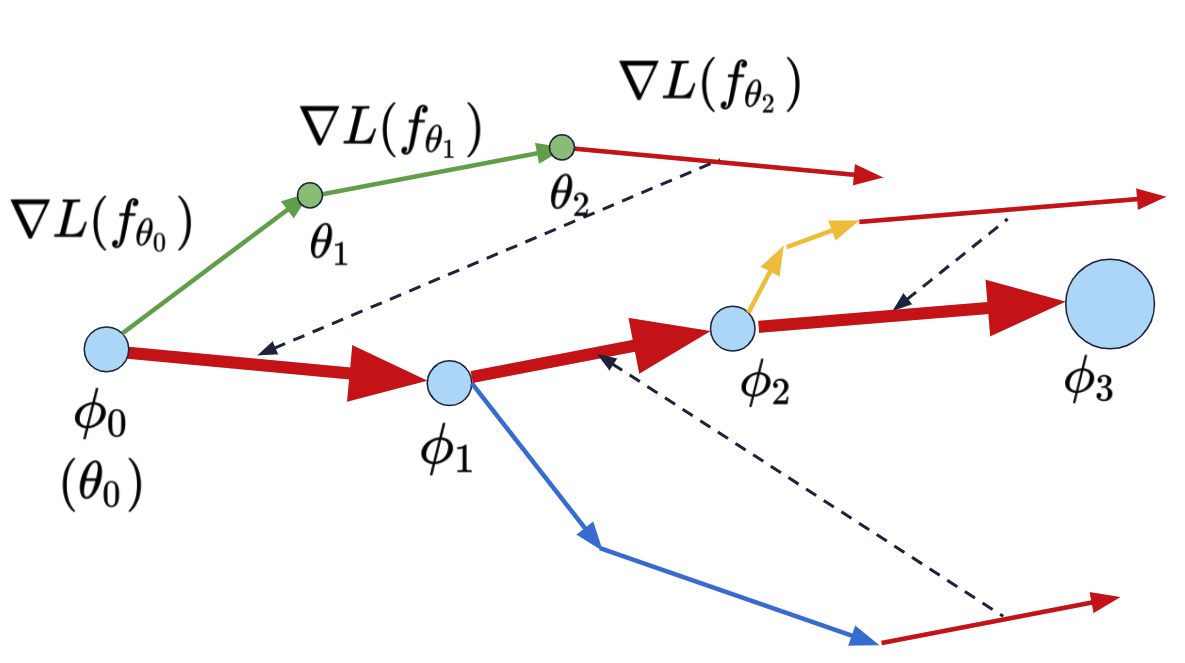

In [13]:
def maml(im_src_batch, label_src_batch, im_q_batch, label_q_batch, 
         n_way, k_shot, q_query, loss_fn, model, inner_train_step=1, 
         inner_lr=0.4, train=True):
    task_loss = []
    task_acc = []
    for images_src, image_q, labels_src, labels_q in zip(im_src_batch, im_q_batch, label_src_batch, label_q_batch):
        model.forward(images_src)
        # 複製meta模型參數
        model_copy = copy_model(model, images_src)
        with tf.GradientTape() as val_tape:
            # 用source task的imgs & labels更新複製的模型參數
            for inner_step in range(inner_train_step):
                with tf.GradientTape() as train_tape:
                    train_loss, train_logits = compute_loss(model, images_src, labels_src)
                grads = train_tape.gradient(train_loss, model.trainable_weights)
                # update weights for model_copy
                k = 0
                for j in range(len(model_copy.layers)):
                    name = model_copy.layers[j].name
                    if 'conv' in name or 'dense' in name:
                        model_copy.layers[j].kernel = tf.subtract(model.layers[j].kernel, tf.multiply(inner_lr, grads[k]))
                        model_copy.layers[j].bias = tf.subtract(model.layers[j].bias, tf.multiply(inner_lr, grads[k+1]))
                        k += 2
                    if 'batch_normalization' in name:
                        model_copy.layers[j].gamma = tf.subtract(model.layers[j].gamma, tf.multiply(inner_lr, grads[k]))
                        model_copy.layers[j].beta = tf.subtract(model.layers[j].beta, tf.multiply(inner_lr, grads[k+1]))
                        k += 2
            # 計算訓練過的model_copy在query資料上的loss
            val_loss, val_logits = compute_loss(model_copy, image_q, labels_q)
        task_loss.append(val_loss)
        acc = acc_fn(labels_q, val_logits).numpy().mean()
        task_acc.append(acc)

        # 用模型在 query 上的結果更新meta模型
        if train:
            test_grads = val_tape.gradient(val_loss, model.trainable_weights)
            optimizer.apply_gradients(zip(test_grads, model.trainable_weights))
            
    meta_batch_loss = np.mean(val_loss)
    meta_batch_acc = np.mean(task_acc)
    return meta_batch_loss, np.mean(task_acc)

# 模型訓練
依照前面設好的meta learning步驟做訓練

In [14]:
for epoch in tqdm(range(max_epoch)):
    print(f'Epoch: {epoch}')
    train_meta_loss = []
    train_acc = []
    # 使用source dataset 訓練模型
    for (im_src_batch, im_q_batch), (label_src_batch, label_q_batch) in tqdm(data_source.batch(BATCH_SIZE)):
        loss_train, acc_train = maml(im_src_batch, label_src_batch, im_q_batch, label_q_batch, 
                                     WAYS, SHOTS, QUERIES, loss_fn, inner_train_step=1, model=model)
        train_meta_loss.append(loss_train)
        train_acc.append(acc_train)
    print('train loss ', np.mean(train_meta_loss))
    print('train acc ', np.mean(train_acc))

    # 使用 target dataset 驗證模型
    val_acc = []
    val_loss = []
    for (im_src_batch, im_q_batch), (label_src_batch, label_q_batch) in data_target.batch(BATCH_SIZE):
        loss, acc = maml(im_src_batch, label_src_batch, im_q_batch, label_q_batch, 
                         WAYS, SHOTS, QUERIES, loss_fn, inner_train_step=3, train=False, model=model)
        val_acc.append(acc)
        val_loss.append(loss)
    print(f'\n val acc : {np.mean(val_acc)} val_loss: {np.mean(val_loss)}')
    

  0%|          | 0/40 [00:00<?, ?it/s]

Epoch: 0


0it [00:00, ?it/s]

train loss  1.1757052
train acc  0.30716464

 val acc : 0.10879629850387573 val_loss: 1.0969265699386597
Epoch: 1


0it [00:00, ?it/s]

KeyboardInterrupt: 

# Exercise
試著修改以下參數，觀察結果如何

1.   WAYS: 3->5, 
2.   SHOTS: 5->3
3.   QUERIES: 1->3 
4.   減少驗證時的inner_train_step, ex: 3 -> 1



# Reference

* [MAML paper](https://arxiv.org/abs/1703.03400)